In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# DATA LOADER

In [3]:
def load_stooq_stock(symbol, years=3):
    url = f"https://stooq.pl/q/d/l/?s={symbol}&i=d"
    df = pd.read_csv(url)

    # Clean column names
    df.columns = [c.strip() for c in df.columns]

    # --- FIX: detect date column safely ---
    if 'Date' in df.columns:
        date_col = 'Date'
    elif 'Data' in df.columns:
        date_col = 'Data'
    else:
        raise ValueError(f"No Date column found for {symbol}. Columns: {df.columns}")

    # Rename other columns
    df.rename(columns={
        'Otwarcie': 'Open',
        'Najwyzszy': 'High',
        'Najnizszy': 'Low',
        'Zamkniecie': 'Close',
        'Wolumen': 'Volume'
    }, inplace=True)

    # Date handling
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)

    # Cutoff to last N years
    cutoff_date = datetime.today() - timedelta(days=365 * years)
    df = df[df.index >= cutoff_date]

    # Returns
    df['returns'] = df['Close'].pct_change()

    return df.dropna()


In [4]:
def build_universe_panel(symbols, years=5):
    """
    Returns:
      prices: DataFrame (Date x Symbol) of Close prices
      rets:   DataFrame (Date x Symbol) of daily returns
    """
    prices = {}
    for sym in symbols:
        df = load_stooq_stock(sym, years=years)  # must include 'Close' and 'returns'
        prices[sym.upper()] = df['Close']
    
    prices = pd.DataFrame(prices).dropna(how='all').sort_index()
    rets = prices.pct_change()
    return prices, rets

# Strategy Logic

In [5]:
def cross_sectional_momentum_long_only(
    prices: pd.DataFrame,
    rets: pd.DataFrame,
    lookback_days: int = 126,  # ~6 months
    top_n: int = 5,
):
    """
    Returns:
      portfolio_daily: Series of daily portfolio returns
      weights_daily:   DataFrame of daily weights (Date x Symbol)
      picks:           dict of {rebalance_date: [symbols picked]}
    """
    # Month-end dates that exist in our trading calendar
    month_ends = prices.resample('M').last().index
    month_ends = [d for d in month_ends if d in prices.index]

    weights_daily = pd.DataFrame(0.0, index=prices.index, columns=prices.columns)
    picks = {}

    for i in range(len(month_ends) - 1):
        reb_date = month_ends[i]
        next_reb_date = month_ends[i + 1]

        # Need enough history for momentum calculation
        idx = prices.index.get_loc(reb_date)
        if idx < lookback_days:
            continue

        # Momentum score = 6m return ending at reb_date
        past_price = prices.iloc[idx - lookback_days]
        now_price = prices.iloc[idx]
        momentum = (now_price / past_price) - 1.0

        # Drop assets with missing values
        momentum = momentum.dropna()

        if len(momentum) < top_n:
            continue

        winners = momentum.sort_values(ascending=False).head(top_n).index.tolist()
        picks[reb_date] = winners

        # Equal weights for the holding period (reb_date next day -> next_reb_date)
        start = reb_date
        end = next_reb_date

        hold_mask = (weights_daily.index > start) & (weights_daily.index <= end)
        weights_daily.loc[hold_mask, winners] = 1.0 / top_n

    # Portfolio daily return = sum(weights_{t-1} * returns_t)
    portfolio_daily = (weights_daily.shift(1) * rets).sum(axis=1)
    portfolio_daily = portfolio_daily.dropna()

    return portfolio_daily, weights_daily, picks


In [6]:
def compute_turnover(weights_daily):
    """
    Daily portfolio turnover = sum of absolute weight changes
    """
    turnover = weights_daily.diff().abs().sum(axis=1)
    return turnover.fillna(0.0)


In [7]:
def apply_transaction_costs(
    portfolio_daily,
    weights_daily,
    cost_rate=0.001  # 10 bps = 0.10%
):
    turnover = compute_turnover(weights_daily)
    cost = cost_rate * turnover
    portfolio_after_cost = portfolio_daily - cost
    return portfolio_after_cost


# Performance Calculation

In [8]:
def perf_stats_from_daily_returns(portfolio_daily: pd.Series):
    r = portfolio_daily.dropna()

    equity = (1 + r).cumprod()
    sharpe = np.sqrt(252) * r.mean() / r.std()

    peak = equity.cummax()
    dd = (equity - peak) / peak

    return {
        "Total Return": equity.iloc[-1] - 1,
        "Sharpe": sharpe,
        "Max Drawdown": dd.min(),
        "Annual Vol": np.sqrt(252) * r.std()
    }


# Action

In [9]:
symbols = [
    # Tech / Growth
    'NVDA.US','AAPL.US','MSFT.US','META.US','AMZN.US','GOOGL.US','AMD.US',

    # Cyclical
    'JPM.US','GS.US','XOM.US','CVX.US','CAT.US',

    # Defensive
    'PG.US','KO.US','UNH.US','COST.US',

    # ETFs
    'SPY.US','QQQ.US','IWM.US','XLK.US','XLF.US','XLE.US','XLV.US','TLT.US'
]

prices, rets = build_universe_panel(symbols, years=7)

portfolio_daily, weights_daily, picks = cross_sectional_momentum_long_only(
    prices=prices,
    rets=rets,
    lookback_days=126,  # 6 months
    top_n=4
)

portfolio_daily_tc = apply_transaction_costs(
    portfolio_daily,
    weights_daily,
    cost_rate=0.001
)

stats = perf_stats_from_daily_returns(portfolio_daily)
net_stats= perf_stats_from_daily_returns(portfolio_daily_tc)
print("Normal statistics:\n",stats)
print("Net statistics:\n",net_stats)


Normal statistics:
 {'Total Return': 6.586161875696652, 'Sharpe': 1.14455262244701, 'Max Drawdown': -0.3117311919821806, 'Annual Vol': 0.2913705823747565}
Net statistics:
 {'Total Return': 6.292765373326688, 'Sharpe': 1.1251275728183732, 'Max Drawdown': -0.3117311919821808, 'Annual Vol': 0.29136287045165676}


In [10]:
portfolio_daily.to_csv("csm_daily_returns.csv")


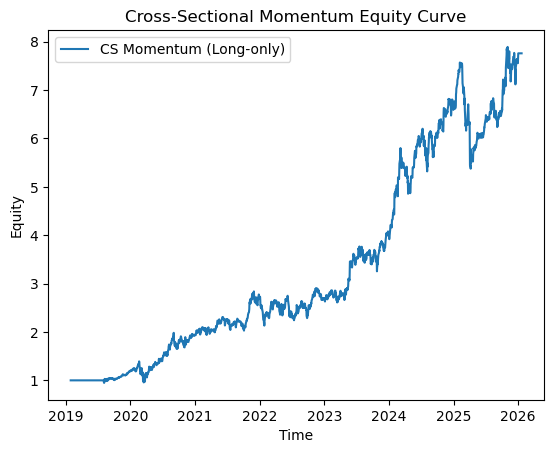

In [10]:
import matplotlib.pyplot as plt

equity = (1 + portfolio_daily).cumprod()

plt.figure()
plt.plot(equity, label='CS Momentum (Long-only)')
plt.xlabel('Time')
plt.ylabel('Equity')
plt.title('Cross-Sectional Momentum Equity Curve')
plt.legend()
plt.show()


In [11]:
print("First 8 rebalance picks:")
for k in list(picks.keys())[:50]:
    print(k.date(), picks[k])

print("Average number of invested stocks per day:",
      (weights_daily.sum(axis=1) > 0).mean())


First 8 rebalance picks:
2019-07-31 ['AMD.US', 'COST.US', 'AAPL.US', 'MSFT.US']
2019-09-30 ['PG.US', 'COST.US', 'KO.US', 'AAPL.US']
2019-10-31 ['COST.US', 'AMD.US', 'PG.US', 'AAPL.US']
2019-12-31 ['AMD.US', 'AAPL.US', 'NVDA.US', 'JPM.US']
2020-01-31 ['AMD.US', 'AAPL.US', 'NVDA.US', 'MSFT.US']
2020-03-31 ['AMD.US', 'NVDA.US', 'TLT.US', 'UNH.US']
2020-04-30 ['AMD.US', 'NVDA.US', 'AMZN.US', 'MSFT.US']
2020-06-30 ['NVDA.US', 'AMZN.US', 'MSFT.US', 'AAPL.US']
2020-07-31 ['NVDA.US', 'AMD.US', 'AMZN.US', 'AAPL.US']
2020-08-31 ['NVDA.US', 'AMD.US', 'AMZN.US', 'AAPL.US']
2020-09-30 ['NVDA.US', 'AAPL.US', 'AMD.US', 'AMZN.US']
2020-11-30 ['AMD.US', 'NVDA.US', 'AAPL.US', 'CAT.US']
2020-12-31 ['AMD.US', 'AAPL.US', 'CAT.US', 'IWM.US']
2021-03-31 ['XOM.US', 'GS.US', 'XLE.US', 'JPM.US']
2021-04-30 ['XOM.US', 'GS.US', 'XLE.US', 'JPM.US']
2021-06-30 ['XOM.US', 'NVDA.US', 'GS.US', 'XLE.US']
2021-08-31 ['NVDA.US', 'META.US', 'GOOGL.US', 'COST.US']
2021-09-30 ['NVDA.US', 'COST.US', 'AMD.US', 'GOOGL.US']
202

In [12]:
def compute_cagr(portfolio_daily):
    equity = (1 + portfolio_daily).cumprod()
    n_days = len(equity)
    years = n_days / 252
    cagr = equity.iloc[-1] ** (1 / years) - 1
    return cagr
cagr = compute_cagr(portfolio_daily)
print("CAGR:", cagr)


CAGR: 0.34179766722384475


In [14]:
import pandas as pd
vcsm = pd.read_csv("vcsm_daily_returns.csv", index_col=0, parse_dates=True, squeeze=True)
csm = portfolio_daily
# Align dates
combined = pd.concat([csm, vcsm], axis=1, join="inner")
combined.columns = ["CSM", "VCSM"]

# Correlation
corr = combined.corr().iloc[0, 1]
print("CSM vs VCSM correlation:", corr)


CSM vs VCSM correlation: 0.9769526758314376


C:\Users\shram\AppData\Local\Temp\ipykernel_29700\1491053375.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  vcsm = pd.read_csv("vcsm_daily_returns.csv", index_col=0, parse_dates=True, squeeze=True)


In [19]:
symbols = [
    # Tech / Growth
    'NVDA.US','AAPL.US','MSFT.US','META.US','AMZN.US','GOOGL.US','AMD.US',

    # Cyclical
    'JPM.US','GS.US','XOM.US','CVX.US','CAT.US',

    # Defensive
    'PG.US','KO.US','UNH.US','COST.US',

    # ETFs
    'SPY.US','QQQ.US','IWM.US','XLK.US','XLF.US','XLE.US','XLV.US','TLT.US'
]

for sym in symbols:
    df = load_stooq_stock(sym, years=5)  # must include 'Close' and 'returns'

In [20]:
df

,Open,High,Low,Close,Volume,returns
Data,,,,,,
2021-01-26,134.780,135.212,134.6310,135.0190,8735960,-0.001922
2021-01-27,135.629,136.002,135.1530,135.3670,8968753,0.002577
2021-01-28,135.039,135.087,133.9570,134.6310,12118234,-0.005437
2021-01-29,133.300,134.245,133.1930,133.8120,17001176,-0.006083
2021-02-01,133.669,134.286,133.5140,133.9710,9265051,0.001188
...,...,...,...,...,...,...
2026-01-14,87.910,88.430,87.8900,88.3300,39233477,0.005807
2026-01-15,88.635,88.660,88.3100,88.3100,37988942,-0.000226
2026-01-16,88.130,88.320,87.7100,87.8000,46382396,-0.005775


In [21]:
prices.head()


,NVDA.US,AAPL.US,MSFT.US,META.US,AMZN.US,GOOGL.US,AMD.US,JPM.US,GS.US,XOM.US,...,UNH.US,COST.US,SPY.US,QQQ.US,IWM.US,XLK.US,XLF.US,XLE.US,XLV.US,TLT.US
Data,,,,,,,,,,,,,,,,,,,,,
2019-01-28,3.42250,37.2795,99.0215,147.47,81.8945,53.7979,20.18,92.6708,182.964,57.0463,...,240.999,198.827,239.266,156.507,139.850,30.4908,23.9875,22.6421,82.6328,102.061
2019-01-29,3.26303,36.8962,97.0241,144.19,79.6940,53.3098,19.25,92.9213,183.678,57.2621,...,241.522,198.399,238.931,155.028,139.522,30.1625,23.9063,22.7113,83.0374,102.583
2019-01-30,3.40703,39.4133,100.2610,150.42,83.5215,54.7012,23.09,93.1434,185.492,57.8865,...,244.240,199.365,242.711,158.957,141.060,31.0995,24.0449,23.0309,84.1760,102.504
2019-01-31,3.56479,39.7009,98.4454,166.69,85.9365,56.0912,24.41,92.3240,181.404,58.6811,...,244.087,202.465,244.838,161.359,142.261,31.0674,24.0073,23.1807,85.2264,103.370
2019-02-01,3.58923,39.7176,96.8755,165.71,81.3115,55.7290,24.51,92.6708,180.043,60.7934,...,242.739,198.369,244.960,160.674,142.380,31.2504,24.1112,23.5843,85.3027,102.751
